# Notebook Introduction

This notebook performs the following on the dataset:
* Train:Test Split
* Scaling via Robust Scaler
* Resamples via SMOTE and/or Random Undersampling
* Fits 3 different classification machine learning models onto the various training datasets and compares the results

The 3 models used are:

    1) Gaussian Naive Bayes

    2) Random Forest

    3) eXtreme Gradient Boosting (XGBoost)

# Library Install

We need to install a previous version of matplotlib, otherwise seaborn heatmaps/confusion matrix will be broken

In [3]:
pip install matplotlib==3.1.0

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


# Library Imports

In [5]:
# Dataframes
import pandas as pd
import numpy as np

# Graphing
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Data Preparation
    # Train:Test
from sklearn.model_selection import train_test_split
    # Scaling
from sklearn.preprocessing import RobustScaler

# Resampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Model Tuning and Cross Validation
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV

# # Model metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.metrics import plot_confusion_matrix

# # Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

/Users/adam/opt/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
# Import functions.py file
import sys
sys.path.append('../')

from functions.functions import *

In [7]:
random_seed = 1

# Introduction

three major approaches to handle imbalanced data: data sampling, algorithm modifications, and cost-sensitive learning.

# Import Cleaned Data 

In [8]:
df = pd.read_csv('../data/processed/cleaned_dataframe.gz', compression='gzip')
df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


# Train:Test Split

In [9]:
X = df.drop(['Class'], axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    stratify=y, 
                                                    random_state=random_seed)

print("No. of samples in each training set:\t{}".format(X_train.shape[0]))
print("No. of samples in each test set:\t{}".format(X_test.shape[0]))

No. of samples in each training set:	199364
No. of samples in each test set:	85443


* We choose to stratify as we want to keep the distribution of classes the same in the training set as the test set. 
* Additionally we must ensure there are at least some fraudulent transactions in the test dataset.

# Scaling

* Scaling the data will improve the predictive performance of some machine learning models.  
    * Without scaling, gradient-based estimating models (such as linear or logistic regression) will take longer to converge or may not be able to converge at all.

In [10]:
scaler = RobustScaler()

* As seen earlier with the "Distribution of Amount", the data is not normally distributed and there are a lot of outliers in our data, so we have chosen to use Robust Scaling, rather than Standard Scaling.

In [11]:
# Fit scaler on training data and transform Training data
X_train = scaler.fit_transform(X_train)

# Use the scaler to transform the Test data
X_test = scaler.transform(X_test)

* We must be careful to only scale the test data using the scaling parameters learned on the train data.

# Resampling

We will be using resampling techniques to improve the effectiveness of our machine learning models
* Resampling involves drawing repeated samples from the original dataset to create a new dataset which either reduces the ratio of the majority class (undersampling) or increases the ratio of the minority class (oversampling). A combination of the two can also be used.

For this project we will be using **Random Undersampling** and **Synthetic Minority Oversampling TEchnique (SMOTE)**.

### Random Undersampling
* This technique under-samples the majority class (legitimate transactions) randomly and uniformly.  
* This can lead to a loss of information, but if the transactions have similar feature values this loss will be minimized. 

### SMOTE
* This technique over-samples the minority class by generating synthetic data.
* This new data is based on the feature space similarities between fraudulent transactions. 
    * It finds the K-nearest neighbors of an individual fraudulent transaction and randomly selects one of them.  
    * A new fraudulent transaction is then synthetically generated in between the original fraud transaction and its neighbor.
    
Note that we **do not resample the test data**, as it represents unseen data. If it is unseen, we will not know which class it falls in, and thus we will not know whether to undersample or oversample it.

In [12]:
# Class distribution before resampling
counter = Counter(y_train)
print('Distribution of data before resampling:')
ratio = round(counter[0]/counter[1], 1)
print('\t0: {:<15}1: {:^10}{:>15} : 1'.format(counter[0], counter[1], ratio))

# Resample the dataset with SMOTE
resample_smote = SMOTE(sampling_strategy=0.1, random_state=random_seed)
X_train_smote, y_train_smote = resample_training_data(resample_smote, X_train, y_train, 'after SMOTE')

# Resample the dataset with Random Undersampling
resample_under = RandomUnderSampler(sampling_strategy=0.5, random_state=random_seed)
X_train_under, y_train_under = resample_training_data(resample_under, X_train, y_train, 'after Random Undersampling')

# Resample the dataset with SMOTE and Random Undersampling
over = SMOTE(sampling_strategy=0.1, random_state=random_seed)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=random_seed)
steps = [('o', over), ('u', under)]
resample_smote_under = Pipeline(steps=steps)
X_train_smote_under, y_train_smote_under = resample_training_data(resample_smote_under, X_train, y_train, 'after SMOTE and Random Undersampling')

Distribution of data before resampling:
	0: 199020         1:    344              578.5 : 1

Distribution of Training Data after SMOTE:
	0: 199020         1:   19902              10.0 : 1

Distribution of Training Data after Random Undersampling:
	0: 688            1:    344                2.0 : 1

Distribution of Training Data after SMOTE and Random Undersampling:
	0: 39804          1:   19902               2.0 : 1


# Modeling

## Pandas Dataframe to keep track of Scores

In [13]:
# Build scores dataframes for comparison
scores_columns = ['Original', 'SMOTE', 'Undersampled', 'SMOTE & Undersampled']
# F1 scores
f1_scores_df = pd.DataFrame(columns=scores_columns)
# Recall scores
recall_scores_df = pd.DataFrame(columns=scores_columns)

## GridSearch

* The function we use makes use of sklearn's GridSearchCV function.  
* Grid Search is an exhaustive search using the parameter values that we provide, in order to optimize our model
    * Not every possible parameter combination is tested, so we can not guarantee a globally optimal combination of parameter values.
    * The model will ony be as good as the possible combinations of parameters that we provide.
    * the more parameter combinations we input, the longer the model will take to run

## Baseline Model & Model Metrics

Due to the high imbalance in our dataset, it is very easy to obtain a high accuracy by simply classifying every observation as the majority class (non-fraud).

In [14]:
# Baseline model that all predictions are majority class
y_pred_base = [0] * len(y_test)

# Calculate Accuracy of Baseline Model
acc_base = round(accuracy_score(y_test, y_pred_base), 5)
print('Baseline Model Accuracy: {}'.format(acc_base))

Baseline Model Accuracy: 0.99827


A model with this level of accuracy will initially seem highly successful, but once we realise it has not caught a single fraudulent transaction, we then realise that **we need a different performance metric to accuracy**.  
   * 99.83% Accuracy can still be used as a starting point, or baseline, from which more sophisticated models can improve upon.

Alternative metrics to Accuracy include:  

### Precision 
* Out of all the frauds our model predicted, what proportion were actually frauds?

\begin{equation*}
\frac{True Positives}{True Positives + False Positives}
\end{equation*}

### Recall
* Out of all the actual frauds, what proportion did our model detect?

\begin{equation*}
\frac{True Positives}{True Positives + False Negatives}
\end{equation*}

### F1 Score
* Considers both Precision and Recall.  Can be interpreted as a weighted average of the two (harmonic mean)

\begin{equation*}
2*\frac{Precision * Recall}{Precision + Recall}
\end{equation*}


**To avoid confusion in this project, True Positive refers to predicting fraud and it is a fraud.**

When seeking to classify fraudulent transactions, the **cost for misclassifying frauds** (False Negative) **is greater than misclassifying a legitimate transaction** (False Positive).
   * An undetected fraud could potentially cost the customer and bank a lot of money.
   * A legitimate transaction, flagged as fraud, may cause inconvenience for the customer and requires a team within the bank to authorize the transaction.
   
For our model we will **focus on the F1 Score** and place more emphasis on a high **Recall** rather than Precision.
* The F1 Score will be the most useful metric as it is includes Recall and Precision.
* Focusing on Recall as well, reflects the fact that classifying frauds (class 1) is more important than classifying legitimate transactions (class 0).

Confusion Matrix: 
TN: 85295 FP: 0 FN: 148 TP: 0


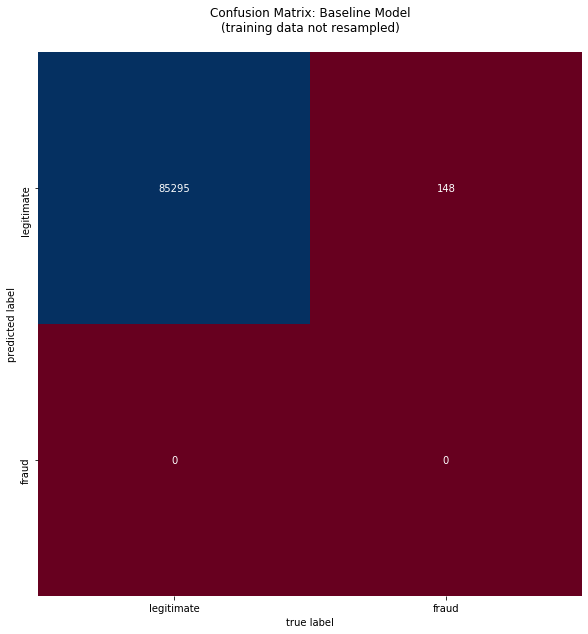

In [15]:
# Confusion matrix for baseline model
custom_confusion_matrix(y_test, y_pred_base, 'Baseline', 'not resampled')

In [16]:
# Calculate F1 Score of Baseline Model
f1_base = round(f1_score(y_test, y_pred_base), 8)
print('Baseline Model F1 Score: {}'.format(f1_base))

Baseline Model F1 Score: 0.0


In [17]:
# Calculate Recall of Baseline Model
recall_base = round(recall_score(y_test, y_pred_base), 8)
print('Baseline Mode Recall Score: {}'.format(recall_base))

Baseline Mode Recall Score: 0.0


Both the Baseline Model's F1 Score and Recall are 0 as the baseline model has a True Positive of 0.

In [18]:
# Update F1 Scores table
f1_scores_df.loc['Baseline'] = [f1_base] * 4

In [19]:
# Update Recall Scores table
recall_scores_df.loc['Baseline'] = [recall_base] * 4

## Gaussian Naive Bayes (GNB)

This classification method is based on Bayes' Theorem and although it is one of the earliest classification techniques, it is still extremey powerful.  

The classifier is essentially asking, "given the Amount = X, the V1 = Y, V2 = Z etc...what is the most likely Class for this observation?"

In [20]:
# Instantiate Gaussian Naive Bayes Classifer
clf_gnb = GaussianNB()

# Build Parameter Grid
param_grid_gnb = {}

### Gaussian Naive Bayes - Original Dataset

In [21]:
# Gaussian Bayes with SMOTE training data
f1_gnb_original, recall_gnb_original, y_pred_gnb_original, y_pred_proba_gnb_original = best_model_score(clf_gnb, param_grid_gnb, X_train, y_train, X_test, y_test)

Best Test Data F1 score: 	0.11738
Best Test Data Recall score: 	0.86486


### Gaussian Naive Bayes - SMOTE

In [22]:
# Gaussian Bayes with SMOTE training data
f1_gnb_smote, recall_gnb_smote, y_pred_gnb_smote, y_pred_proba_gnb_smote = best_model_score(clf_gnb, param_grid_gnb, X_train_smote, y_train_smote, X_test, y_test)

Best Test Data F1 score: 	0.11121
Best Test Data Recall score: 	0.86486


### Gaussian Naive Bayes - RandomUndersampling

In [23]:
# Gaussian Bayes with Undersampled training data
f1_gnb_under, recall_gnb_under, y_pred_gnb_under, y_pred_proba_gnb_under = best_model_score(clf_gnb, param_grid_gnb, X_train_under, y_train_under, X_test, y_test)

Best Test Data F1 score: 	0.12187
Best Test Data Recall score: 	0.87162


### Gaussian Naive Bayes - SMOTE & RandomUndersampling

In [24]:
# Gaussian Bayes with SMOTE and Undersampled training data
f1_gnb_smote_under, recall_gnb_smote_under, y_pred_gnb_smote_under, y_pred_proba_gnb_smote_under = best_model_score(clf_gnb, param_grid_gnb, X_train_smote_under, y_train_smote_under, X_test, y_test)

Best Test Data F1 score: 	0.10441
Best Test Data Recall score: 	0.87162


In [25]:
# Update F1 Scores table
f1_scores_df.loc['Gaussian Naive Bayes'] = [f1_gnb_original, f1_gnb_smote, f1_gnb_under, f1_gnb_smote_under]

In [26]:
# Update Recall Scores table
recall_scores_df.loc['Gaussian Naive Bayes'] = [recall_gnb_original, recall_gnb_smote, recall_gnb_under, recall_gnb_smote_under]

## Random Forest

A Random Forest classifier uses an ensemble of decision trees that are trained using different portions of the data and different combinations of features. The forests predicts based on what the majority of trees in the forest predict.

In [27]:
# Instantiate Random Forest Classifer
clf_rf = RandomForestClassifier(criterion='gini', 
                                class_weight={0: 1, 1: 2}, 
                                n_jobs=-1, 
                                random_state=random_seed)

# Build Parameter Grid
param_grid_rf = {'n_estimators': [50], 
                   'max_depth': [30, None], 
                 'min_samples_leaf': [1,3], 
                   'min_samples_split': [3,4]
                  }

### Parameter Tuning Guide - Random Forest

*criterion*
* The function to measure the quality of a split.
* "Gini" (Gini impurity) will often produce the same results as "Entropy" (information gain) but Entropy is more computaionally expensive.

*class_weight*
* Weights associated with classes in the form {class_label: weight}.
* We want our model to focus more on catching frauds, than catching legitimate transactions.

*n_estimators*
* Increasing this will improve the model as predictions will be based off a larger number of "votes", but it will also make it more computationally expensive

*max_depth*
* The max depth of the trees.  
* Too large and we risk overfitting the data.
* Too small and we prevent the trees being able to explain some of the variation in the data.

*min_samples_leaf*
* Minimum number of samples required to be at a leaf node.  
* Too large will risk the trees not splitting enough to capture sufficient variation in the data

*min_samples_split*
* Minimum number of samples required to split an internal node
* Too large will cause under-fitting as the trees won't be able to split enough to achieve node purity

### Random Forest - Original Dataset

In [28]:
f1_rf_original, recall_rf_original, y_pred_rf_original, y_pred_proba_rf_original = best_model_score(clf_rf, param_grid_rf, X_train, y_train, X_test, y_test)

Best Test Data F1 score: 	0.88571
Best Test Data Recall score: 	0.83784

Optimal parameters:
	max_depth: 30
	min_samples_leaf: 1
	min_samples_split: 3
	n_estimators: 50


### Random Forest - SMOTE

In [29]:
f1_rf_smote, recall_rf_smote, y_pred_rf_smote, y_pred_proba_rf_smote = best_model_score(clf_rf, param_grid_rf, X_train_smote, y_train_smote, X_test, y_test)

Best Test Data F1 score: 	0.87973
Best Test Data Recall score: 	0.86486

Optimal parameters:
	max_depth: None
	min_samples_leaf: 1
	min_samples_split: 3
	n_estimators: 50


### Random Forest - RandomUndersampling

In [30]:
f1_rf_under, recall_rf_under, y_pred_rf_under, y_pred_proba_rf_under = best_model_score(clf_rf, param_grid_rf, X_train_under, y_train_under, X_test, y_test)

Best Test Data F1 score: 	0.22259
Best Test Data Recall score: 	0.89865

Optimal parameters:
	max_depth: 30
	min_samples_leaf: 3
	min_samples_split: 3
	n_estimators: 50


### Random Forest - SMOTE & RandomUndersampling

In [31]:
f1_rf_smote_under, recall_rf_smote_under, y_pred_rf_smote_under, y_pred_proba_rf_smote_under = best_model_score(clf_rf, param_grid_rf, X_train_smote_under, y_train_smote_under, X_test, y_test)

Best Test Data F1 score: 	0.82243
Best Test Data Recall score: 	0.89189

Optimal parameters:
	max_depth: 30
	min_samples_leaf: 1
	min_samples_split: 4
	n_estimators: 50


In [32]:
# Update F1 Scores table
f1_scores_df.loc['Random Forest'] = [f1_rf_original, f1_rf_smote, f1_rf_under, f1_rf_smote_under]

In [33]:
# Update Recall Scores table
recall_scores_df.loc['Random Forest'] = [recall_rf_original, recall_rf_smote, recall_rf_under, recall_rf_smote_under]

## XGBoost

eXtreme Gradient Boosting (XGBoost) is a form of gradient-boosted decision trees. 

In a standard ensemble method such as Random Forest, models are trained in isolation so all of the models might make the same mistakes.

Gradient Boosting methods, such as XGBoost, trains the Trees in succession.  
* Each new Tree is trained to correct the errors made by the previous Trees.  
* Trees are added sequentially until either no further improvements can be made or a specified number of trees is reached.
* Note that Boosted classifiers do not necessarily have to be tree-based, though often are.




In [34]:
# Instantiate XGBClassifier
scale_pos_weight = 10
clf_xgb = XGBClassifier(booster='gbtree', tree_method='hist', scale_pos_weight=scale_pos_weight, verbosity=0,
                    seed=random_seed
                   )

# Build Parameter Grid
param_grid_xgb = {
    'learning_rate': [0.2, 0.3],
    'objective': ['binary:hinge'],
    'max_depth': [30, 50],
    'min_child_weight': [3],
}

### Parameter Tuning Guide - XGBoost

*booster*
* "gbtree" uses tree based models

*tree_method*
* "hist" allows for faster computation

*scale_pos_weight
* Ratio of legitimate transactions to frauds.
* This helps the model deal with imbalanced datasets.

*learning_rate*
* This is the step size shrinkage used in each update.  It prevents overfitting

*objective*
* "binary:hinge" is for binary classification.  A prediction of 0 or 1 is output, rather than producing probabilities

*max_depth*
* Max number of nodes from root to furthest leaf.
* Too large and splits will eventually become less relevant and overfitting will occur.
* Too small and we won't be able to model more complex relationships in the data.

*min_child_weight*
* Min weight or number of samples needed to create a new node.
* Too large and our model will not be able to create children to correspond to 
* Too small and we risk overfitting

### XGBoost - Original Dataset

In [35]:
# Find class weights required
clf_xgb.scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# Fit model
f1_xgb_original, recall_xgb_original, y_pred_xgb_original, y_pred_proba_xgb_original = best_model_score(clf_xgb, 
                                                                                                        param_grid_xgb, 
                                                                                                        X_train, 
                                                                                                        y_train, 
                                                                                                        X_test, 
                                                                                                        y_test)

Best Test Data F1 score: 	0.86525
Best Test Data Recall score: 	0.82432

Optimal parameters:
	learning_rate: 0.2
	max_depth: 30
	min_child_weight: 3
	objective: binary:hinge


### XGBoost - SMOTE

In [36]:
# Find class weights required
clf_xgb.scale_pos_weight = y_train_smote.value_counts()[0] / y_train_smote.value_counts()[1]

# Fit model
f1_xgb_smote, recall_xgb_smote, y_pred_xgb_smote, y_pred_proba_xgb_smote = best_model_score(clf_xgb, 
                                                                                            param_grid_xgb, 
                                                                                            X_train_smote, 
                                                                                            y_train_smote, 
                                                                                            X_test, 
                                                                                            y_test)

Best Test Data F1 score: 	0.86195
Best Test Data Recall score: 	0.86486

Optimal parameters:
	learning_rate: 0.2
	max_depth: 30
	min_child_weight: 3
	objective: binary:hinge


### XGBoost - RandomUndersampling

In [37]:
# Find class weights required
clf_xgb.scale_pos_weight = y_train_under.value_counts()[0] / y_train_under.value_counts()[1]

# Fit model
f1_xgb_under, recall_xgb_under, y_pred_xgb_under, y_pred_proba_xgb_under = best_model_score(clf_xgb, 
                                                                                            param_grid_xgb, 
                                                                                            X_train_under, 
                                                                                            y_train_under, 
                                                                                            X_test, 
                                                                                            y_test)

Best Test Data F1 score: 	0.11703
Best Test Data Recall score: 	0.89865

Optimal parameters:
	learning_rate: 0.2
	max_depth: 30
	min_child_weight: 3
	objective: binary:hinge


### XGBoost - SMOTE & RandomUndersampling

In [38]:
# Find class weights required
clf_xgb.scale_pos_weight = y_train_smote_under.value_counts()[0] / y_train_smote_under.value_counts()[1]

# Fit model
f1_xgb_smote_under, recall_xgb_smote_under, y_pred_xgb_smote_under, y_pred_proba_xgb_smote_under = best_model_score(clf_xgb, 
                                                                                                                    param_grid_xgb, 
                                                                                                                    X_train_smote_under, 
                                                                                                                    y_train_smote_under, 
                                                                                                                    X_test, 
                                                                                                                    y_test)

Best Test Data F1 score: 	0.6514
Best Test Data Recall score: 	0.86486

Optimal parameters:
	learning_rate: 0.2
	max_depth: 30
	min_child_weight: 3
	objective: binary:hinge


In [39]:
# Update F1 Scores table
f1_scores_df.loc['XGBoost'] = [f1_xgb_original, f1_xgb_smote, f1_xgb_under, f1_xgb_smote_under]

In [40]:
# Update Recall Scores table
recall_scores_df.loc['XGBoost'] = [recall_xgb_original, recall_xgb_smote, recall_xgb_under, recall_xgb_smote_under]

# Analysis of Results

## F1 Scores

In [41]:
f1_scores_df

,Original,SMOTE,Undersampled,SMOTE & Undersampled
Baseline,0.000000,0.000000,0.000000,0.000000
Gaussian Naive Bayes,0.117377,0.111208,0.121871,0.104411
Random Forest,0.885714,0.879725,0.222594,0.822430
XGBoost,0.865248,0.861953,0.117026,0.651399


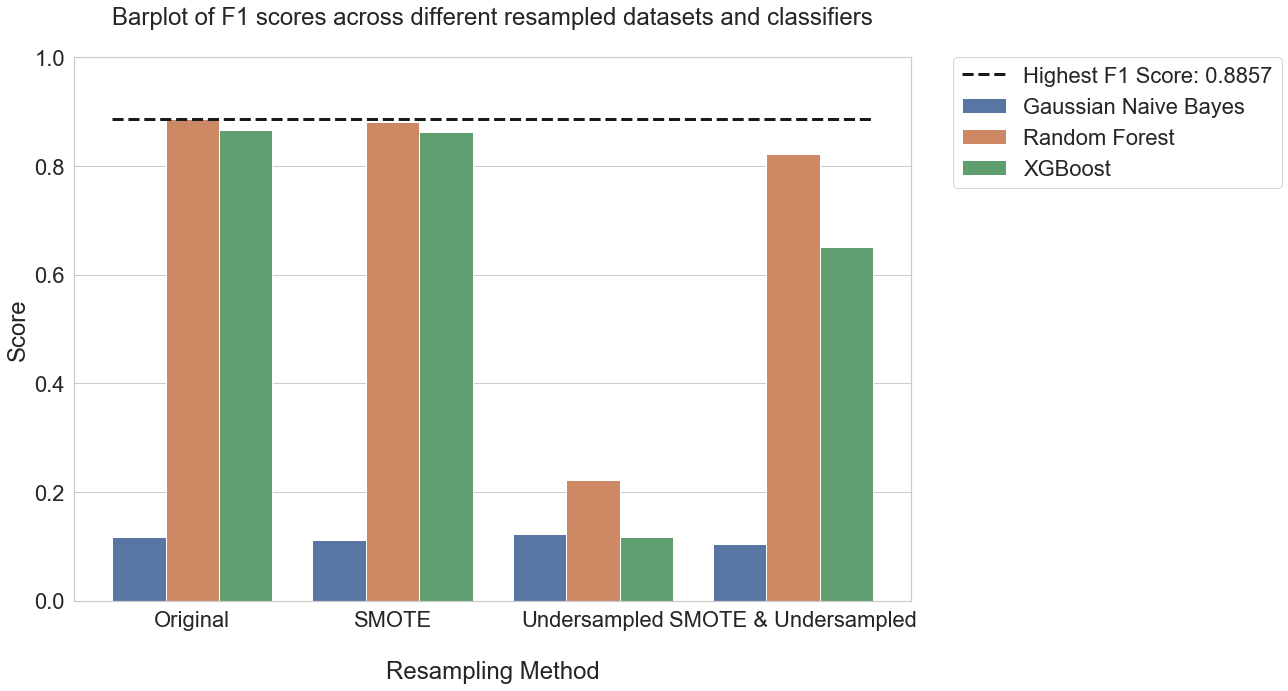

In [42]:
scores_bar_plot(reshape_scores_df(f1_scores_df), 'F1')

In [43]:
max_f1 = combination_for_best_score(f1_scores_df)

The highest score was 0.8857
This was achieved by resampling with Original and using the Random Forest classifier


* The best F1 Scores came from using Random Forest on the Original training data and the SMOTE resampled training data.
* With such close performances it is worth investigating the performances with other metrics

## Recall Scores

* Out of all the actual frauds, what proportion did our model detect?

\begin{equation*}
\frac{True Positives}{True Positives + False Negatives}
\end{equation*}

In [44]:
recall_scores_df

,Original,SMOTE,Undersampled,SMOTE & Undersampled
Baseline,0.000000,0.000000,0.000000,0.000000
Gaussian Naive Bayes,0.864865,0.864865,0.871622,0.871622
Random Forest,0.837838,0.864865,0.898649,0.891892
XGBoost,0.824324,0.864865,0.898649,0.864865


In [45]:
# How many fraud transactions are in our test data?
print('There are {} fraud transactions in our test data'.format(y_test.value_counts()[1]))

There are 148 fraud transactions in our test data


* There appears to be many duplicated Recall Scores. 
    * An explanation could be that as there are only 148 fraud cases in the test data
    * It is quite likely that the model duplicates a recall calculation (i.e. finds TP=120 and FN=20 on more than one occasion)

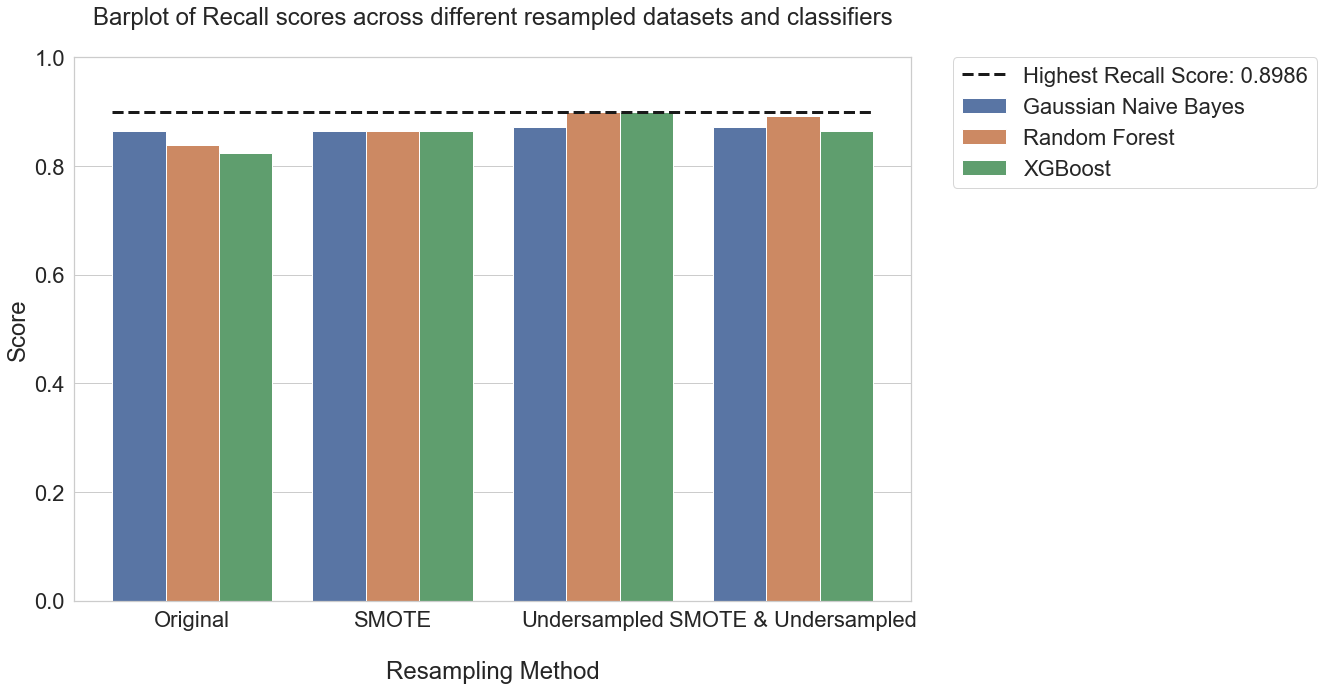

In [46]:
scores_bar_plot(reshape_scores_df(recall_scores_df), 'Recall')

In [47]:
max_recall = combination_for_best_score(recall_scores_df)

The highest score was 0.8986
This was achieved by resampling with Undersampled and using the Random Forest classifier


* Although the highest Recall scores came from the Undersampled training data, this data performed horribly in the F1 scores.  
* Once again the Original training data and the training data resampled with SMOTE have performed very similarly.  Further comparison is needed to choose a best combination.

## Confusion Matrix

* By analysing a confusion matrix of the two best performing models, we can look in particular at the False Negatives (i.e. the frauds that went undetected)

### Confusion Matrix - Random Forest, Original Training Data

Confusion Matrix: 
TN: 85287 FP: 8 FN: 24 TP: 124


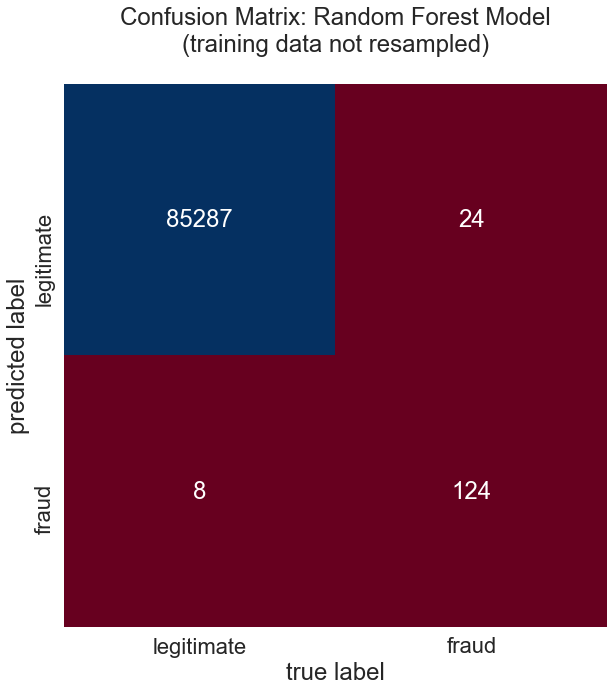

In [48]:
custom_confusion_matrix(y_test, y_pred_rf_original, 'Random Forest', 'not resampled')

### Confusion Matrix - Random Forest, Training Data Resampled with SMOTE

Confusion Matrix: 
TN: 85280 FP: 15 FN: 20 TP: 128


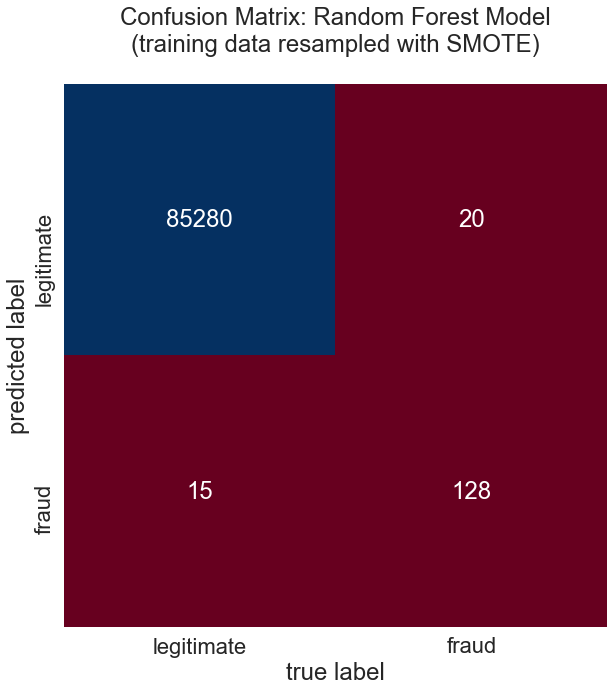

In [49]:
custom_confusion_matrix(y_test, y_pred_rf_smote, 'Random Forest', 'resampled with SMOTE', save_fig=True)

* Although the SMOTE model had higher False Positives, it had 4 fewer False Negatives, representing a 17% drop.

## Precision-Recall Curve

* The ROC (Receiver Operating Characteristic) curve is often used to assess machine learning models.  In this project however, the **ROC curve is not useful**.
    * It does not measure well for imbalanced data.
    * ROC curve does not measure the effects of negatives (as it uses the True Positive Rate) 
    * The AUC (Area Under the Curve) helps with assessing overall performance of the model but treats both classes equally.  
* We instead **must look at the PR (Precision-Recall) curve** to visualize how well our models have captured True Positives.  
    * The PR curve shows us how the model minimizes False Positives and False Negatives (very important for fraud detection)
    * With the highly imbalanced data, the AUC of the PR curve is also more sensitive than the ROC curve. This makes it easier to interpret

* The PR curve includes a "no-skill" baseline.
    * This is determined by the ratio of positives and negatives or P / (P + N)
* A perfect skil model will have a point at (1,1).
* The F1 Score measures the model skill for a specific probability threshold.
* The Area Under the Curve (AUC) summarizes the integral of the PR curve. i.e. the skill of the model across thresholds.
* Both F1 Score and AUC are useful measures for binary classification problems which have an imbalance in the dataset.

### PR curve for Random Forest with Original dataset

In [50]:
y_pred_proba_rf_original

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [51]:
y_pred_proba_rf_original[:,1]

array([0., 0., 0., ..., 0., 0., 0.])

Random Forest with no resampling: F1: 0.8857	AUC: 0.8742


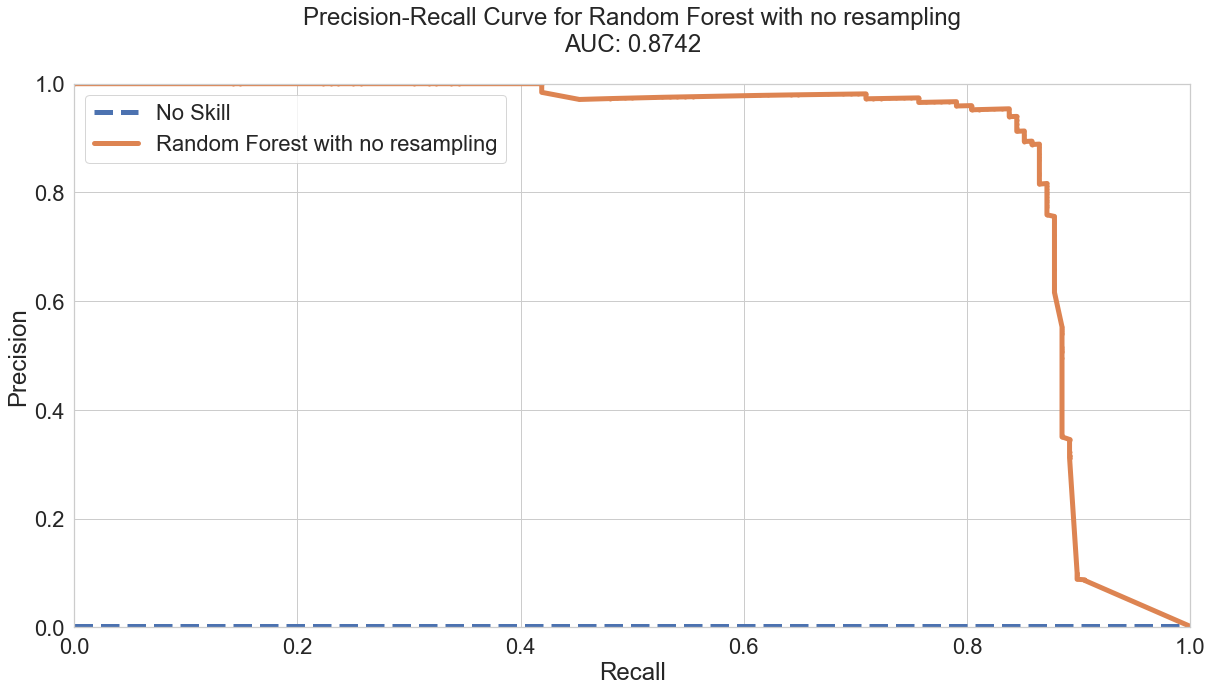

In [52]:
plot_pr_curve(y_test, y_pred_rf_original, y_pred_proba_rf_original, 'Random Forest with no resampling')

### PR curve for Random Forest with SMOTE

Random Forest with SMOTE: F1: 0.8797	AUC: 0.8818


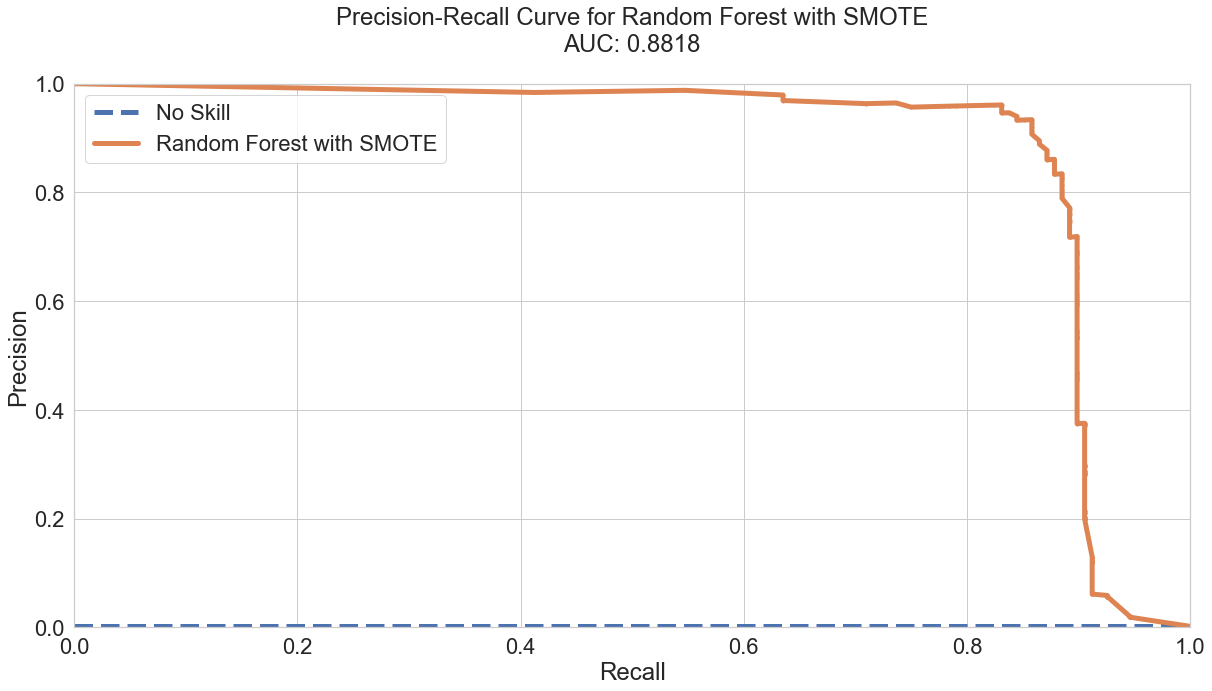

In [53]:
plot_pr_curve(y_test, y_pred_rf_smote, y_pred_proba_rf_smote, 'Random Forest with SMOTE')

# Conclusion

* The AUC for the SMOTE dataset is higher than that for the orginal dataset, which means the model is more effective across thresholds.
* Our most effective model came from using a Random Forest Classifier and resamping the dataset with SMOTE.